# Prepare the Notebook

In [ ]:
# Download the dataset
!wget https://github.com/aleksandar-aleksandrov/groceries-object-detection-dataset/archive/master.zip

# Download annotations
!7z x -y master.zip

In [ ]:
!cd groceries-object-detection-dataset-master
!ls
!ls groceries-object-detection-dataset-master

In [ ]:
!pip install tensorflow==2.0

In [1]:
# Imports
from pathlib import Path
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, Dropout, Reshape, Conv2D
from tensorflow.keras.models import Model
import pandas as pd
import xml.etree.ElementTree as ET
from tensorflow.keras.optimizers import SGD, Adam

print(tf.__version__)

2.0.0


In [2]:
# Define global Variables
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
TRAIN_DATASET_SIZE = 4960
CHANNELS = 3
EPOCHS = 800

# The image is divided into 4x4 grid of cells
S = 4
# Amount of Bounding Boxes. Each BB is a tuple of type (x, y, w, h, confidence)
B = 1
B_SIZE = 5

# Class Labels
CLASS_LABELS = [
    'beans', 'cake', 'candy', 'cereal', 'chips', 'chocolate', 'coffee', 'corn',
    'fish', 'flour', 'honey', 'jam', 'juice', 'milk', 'nuts', 'oil', 'pasta',
    'rice', 'soda', 'spices', 'sugar', 'tea', 'tomato_sauce', 'vinegar', 'water'
]

C = len(CLASS_LABELS)


# Prepare the Data

In [ ]:
def get_objects(file):
    root = ET.parse(file).getroot()

    objs = []
    for child in root.iter('object'):
        obj = {}
        obj['class'] = child.find('name').text
        
        bndbox = child.find('bndbox')
        obj['xmax'] = float(bndbox.find('xmax').text)
        obj['xmin'] = float(bndbox.find('xmin').text)
        obj['ymax'] = float(bndbox.find('ymax').text)
        obj['ymin'] = float(bndbox.find('ymin').text)

        objs.append(obj)

    return objs

def get_objects_array(file):
    objects = get_objects(file)
    array = np.zeros((S, S, B, 5 + C))
            
    for obj in objects:
        confidence = 1

        center_x = .5*(obj['xmin'] + obj['xmax'])
        center_x = center_x / (IMG_HEIGHT / S)
        x = center_x - np.floor(center_x)
        grid_x = int(np.floor(center_x))

        center_y = .5*(obj['ymin'] + obj['ymax'])
        center_y = center_y / (IMG_WIDTH / S)
        y = center_y - np.floor(center_y)
        grid_y = int(np.floor(center_y))

        w = (obj['xmax'] - obj['xmin']) / IMG_HEIGHT
        h = (obj['ymax'] - obj['ymin']) / IMG_WIDTH

        class_array = [0.] * C
        class_array[CLASS_LABELS.index(obj['class'])] = 1.

        array[grid_x, grid_y, 0] = [x] + [y] + [w] + [h] + [confidence] + class_array
    
    return array

def load_dataset(dataset_size):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

    X = np.zeros((dataset_size, IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    Y = np.zeros((dataset_size, S, S, B, 5 + C))

    index = 0
    labels_path = Path(f'/content/groceries-object-detection-dataset-master/dataset/annotations')
    img_path = Path(f'/content/groceries-object-detection-dataset-master/dataset/images')

    for class_dir in labels_path.iterdir():
        for file in class_dir.iterdir():
            img_paths = str(file).replace('annotations', 'images').replace('.xml', '.png')
            img = tf.keras.preprocessing.image.load_img(img_paths)
            img_arr = tf.keras.preprocessing.image.img_to_array(img)
            X[index] = img_arr
            Y[index] = get_objects_array(file)
            index += 1

            if index >= dataset_size:
                break
        if index >= dataset_size:
              break
    Y = np.asarray(Y).astype('float32')
    return image_generator.flow(X, Y, batch_size=BATCH_SIZE)
                    
def show_batch(dataset):
        image_batch, label_batch = next(dataset)
        image_batch = list(image_batch)
        label_batch = list(label_batch)

        plt.figure(figsize=(10, 10))
        for n in range(4):
            ax = plt.subplot(2, 2, n + 1)
            plt.imshow(image_batch[n])
            plt.axis('off')

        plt.show()

train_dataset = load_dataset(TRAIN_DATASET_SIZE)
show_batch(train_dataset)


# Create the model

In [ ]:
def get_base_model():
    return tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), classes=C)

In [ ]:
def freeze_trained_layers(model):
    for layer in model.layers:
        layer.trainable=False
        
    return model

def get_yolo_model():
    base_model = get_base_model()
    base_model = freeze_trained_layers(base_model)

    x = Conv2D(B * (5 + C), (3,3), strides=(2,2), padding='same', kernel_initializer='lecun_normal')(base_model.output)
    x = Conv2D(B * (5 + C), (1,1), strides=(1,1), padding='same', kernel_initializer='lecun_normal')(x)
    x = Reshape((S, S, B, 5 + C))(x)

    return Model(base_model.input, x)

# Train the model

In [5]:
def yolo_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
        
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(S), [S]), (1, S, S, 1, 1)), dtype=tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, B, 1])
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.sigmoid(y_pred[..., 2:4])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    #iou_scores = 1

    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1)
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = tf.expand_dims(true_box_xy, 4)
    true_wh = tf.expand_dims(true_box_wh, 4)
    
    true_wh_half = true_wh / 2.
    true_mins    = true_wh_half
    true_maxes   = true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.cast(best_ious < 0.6,dtype=tf.float32) * (1 - y_true[..., 4]) * 0.5
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * 0.5
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_wt = tf.ones(C)
    class_mask = y_true[..., 4] * tf.gather(class_wt, true_box_class) * 0.5       
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0,dtype=tf.float32))
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, dtype=tf.float32))
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, dtype=tf.float32))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask) / (nb_conf_box + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class * 10

    return loss

In [ ]:
model = get_yolo_model()
model.summary()

In [ ]:
model.compile(optimizer=SGD(lr=2e-4, momentum=0.9), loss=yolo_loss)

history = model.fit(train_dataset, epochs = EPOCHS)

# Visualize Results


In [ ]:
# Function to visualize training history
import matplotlib.pyplot as plt

def plot_loss(history):
    training_loss = history.history['loss']
    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.legend(['Training Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_loss(history)

# Save the model

In [ ]:
# Convert to TFLite Format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open("converted_model.tflite", "wb").write(tflite_model)

In [ ]:
from google.colab import files

# Download tflite model
files.download('/content/converted_model.tflite')

In [ ]:
# Save the trained model
tf.saved_model.save(model, "/content/model")

In [ ]:
!zip -r /content/model.zip /content/model

In [ ]:
files.download('/content/model.zip')

In [ ]:
# Save the loss
open("/content/history.txt", "w").write(str(history.history['loss']))

In [ ]:
files.download('/content/history.txt')

# Test the trained model

In [21]:
import math
import matplotlib.patches as patches

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def get_label_bounding_boxes(label):
    x_a, y_a, w_a, h_a = 0, 0, 0, 0
    xs, ys, ws, hs = [], [], [], []
    for i in range(S):
        for j in range(S):
            for b in range(B):
                bb_box = label[i][j][b]
                
                if bb_box[0] != 0:
                    x_a = bb_box[0]
                    y_a = bb_box[1]
                    w_a = bb_box[2] * IMG_WIDTH
                    h_a = bb_box[3] * IMG_HEIGHT
                    
                    x_a = (i + x_a)*56 - w_a / 2
                    y_a = (j + y_a)*56 - h_a / 2
                    xs.append(x_a)
                    ys.append(y_a)
                    ws.append(w_a)
                    hs.append(h_a)
    return xs, ys, ws, hs
  
def get_predicted_bounding_boxes(result):
    bb_boxes = []
    for i in range(S):
        for j in range(S):
              for b in range(B):
                bb_box = result[0][i][j][b]
        
                x = sigmoid(bb_box[0])
                y = sigmoid(bb_box[1])
                w = sigmoid(bb_box[2])
                h = sigmoid(bb_box[3])

                confidence = sigmoid(bb_box[4])

                max_class = 0
                max_class_index = -1
                class_sum = 0
                for c in range(5, C + 5):
                    class_value = math.exp(bb_box[c])
                    if class_value >= max_class:
                        max_class = class_value
                        max_class_index = c - 5

                    class_sum +=  class_value

                real_x = (i + x)*56 - (w*IMG_WIDTH) / 2
                real_x = real_x if real_x > 0 else 0
                real_y = (j + y)*56 - (h*IMG_HEIGHT) / 2
                real_y = real_y if real_y > 0 else 0
                bb_boxes.append({
                    'x': real_x,
                    'y': real_y,
                    'w': w * IMG_WIDTH,
                    'h': h * IMG_HEIGHT,
                    'confidence': confidence,
                    'class': CLASS_LABELS[max_class_index],
                    'class_probability': max_class / class_sum
                })
    return bb_boxes

def plot_gt_predictions(ground_truth, predictions):
    xs, ys, ws, hs = get_label_bounding_boxes(ground_truth)                
    bb_boxes = get_predicted_bounding_boxes(predictions)

    fig, ax = plt.subplots(1)
    ax.imshow(img_arr)

    for j in range(len(xs)):
        rect1 = patches.Rectangle((xs[j], ys[j]),ws[j],hs[j],linewidth=5,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
    print(f'GROUNDTRUTH Class: Coffee, Color: red')
    print('----------------------------------------------------')
    print('PREDICTIONS:')
    print('----------------------------------------------------')
    
    bb_boxes.sort(key=lambda x: x['class_probability'], reverse=True)
    bb_boxes = bb_boxes[:5]
    bb_boxes.sort(key=lambda x: x['class_probability'], reverse=True)
    for index, color in enumerate(['y', 'g', 'b', 'c', 'm']):
        width = bb_boxes[index]['w'] if bb_boxes[index]['w'] + bb_boxes[index]['x'] < 224 else 224
        height = bb_boxes[index]['h'] if bb_boxes[index]['h'] + bb_boxes[index]['y'] < 224 else 224
        rect = patches.Rectangle((bb_boxes[index]['x'],bb_boxes[index]['y']),width,height,linewidth=3,edgecolor=color,facecolor='none')
        ax.add_patch(rect)
        print('CLASS: ' + bb_boxes[index]["class"] + ' Color: ' + color + ' Prob: ' + str(bb_boxes[index]["class_probability"]) + ' Confidence: ' + str(bb_boxes[index]["confidence"]))

    plt.show()

In [22]:
import os

current_path = Path(os.getcwd()).absolute()

model_path = current_path.parent.joinpath('main-model/model.h5')
model = tf.keras.models.load_model(str(model_path), custom_objects={'yolo_loss2': yolo_loss})

image_path = current_path.joinpath('example/image.png')
img = tf.keras.preprocessing.image.load_img(image_path)
img_arr = tf.keras.preprocessing.image.img_to_array(img) / 255.

label_path = current_path.joinpath('example/label.xml')
ground_truth_labels = get_objects_array(label_path)

GROUNDTRUTH Class: Coffee, Color: red
----------------------------------------------------
PREDICTIONS:
----------------------------------------------------
CLASS: coffee Color: y Prob: 0.999999454623329 Confidence: 2.0471075880638878e-13
CLASS: coffee Color: g Prob: 0.9992617158318371 Confidence: 3.451635713579655e-14
CLASS: flour Color: b Prob: 0.9625394794078695 Confidence: 1.7649663660328303e-09
CLASS: cereal Color: c Prob: 0.8495247514752429 Confidence: 6.476671088424291e-10
CLASS: juice Color: m Prob: 0.821969981945008 Confidence: 0.0009740280706662939


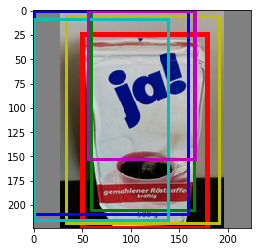

In [23]:
labels_predictions = model.predict(np.array([img_arr]))
plot_gt_predictions(ground_truth_labels, labels_predictions)